In [481]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [482]:
client = InfluxDBClient(host='140.112.42.160', port=8086, database='test_2')

In [483]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'west-eu': 'Europe',
        'west-us': 'West US',
    }

In [484]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

ground truth 

In [551]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']

In [552]:
GT_one_day = np.zeros((len(date),), dtype = int)
gt_one_day_tran = np.zeros((len(date),), dtype = int)
GT_one_hr_8am = np.zeros((len(date),), dtype = int)
gt_one_hr_8am_tran = np.zeros((len(date),), dtype = int)
GT_two_hr_8am = np.zeros((len(date),), dtype = int)
gt_two_hr_8am_tran = np.zeros((len(date),), dtype = int)
GT_one_hr_4pm = np.zeros((len(date),), dtype = int)
gt_one_hr_4pm_tran = np.zeros((len(date),), dtype = int)
GT_two_hr_4pm = np.zeros((len(date),), dtype = int)
gt_two_hr_4pm_tran = np.zeros((len(date),), dtype = int)

In [555]:
def get_server_ip_gt(date, date_1, day, loc, lang=None):
    # GT -- one day
    st = f'2019-{date}T00:00:00Z' 
    et = f'2019-{date_1}T00:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result)
    GT_one_day[day] = len(gt)
    gt_one_day_tran[day] = gt_t
    
    # GT -- one hour @ 8am
    st = f'2019-{date}T08:00:00Z' 
    et = f'2019-{date}T09:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result)
    GT_one_hr_8am[day] = len(gt)
    gt_one_hr_8am_tran[day] = gt_t
    
    # GT -- two hour @ 8am
    st = f'2019-{date}T08:00:00Z' 
    et = f'2019-{date}T10:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result)
    GT_two_hr_8am[day] = len(gt)
    gt_two_hr_8am_tran[day] = gt_t
    
    # GT -- one hour @ 4pm
    st = f'2019-{date}T16:00:00Z' 
    et = f'2019-{date}T17:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result)
    GT_one_hr_4pm[day] = len(gt)
    gt_one_hr_4pm_tran[day] = gt_t
    
    # GT -- two hour @ 4pm
    st = f'2019-{date}T16:00:00Z' 
    et = f'2019-{date}T18:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result)
    GT_two_hr_4pm[day] = len(gt)
    gt_two_hr_4pm_tran[day] = gt_t

In [556]:
for d, (date1, date2) in enumerate(zip(date, date_1)):
    get_server_ip_gt(date1, date2, d, 'west-us')

print("GT_one_day")
print(GT_one_day)
print(gt_one_day_tran)
print()
print("GT_one_hr_8am")
print(GT_one_hr_8am)
print(gt_one_hr_8am_tran)
print()
print("GT_two_hr_8am")
print(GT_two_hr_8am)
print(gt_two_hr_8am_tran)
print()
print("GT_one_hr_4pm")
print(GT_one_hr_4pm)
print(gt_one_hr_4pm_tran)
print()
print("GT_two_hr_4pm")
print(GT_two_hr_4pm)
print(gt_two_hr_4pm_tran)
print()

GT_one_day
[131 135 131 132 141 128 152 133 140 152 128 130 131 129]
[331715 363885 341492 320152 327913 315358 291054 320451 317502 278662
 284515 212132 260809 264912]

GT_one_hr_8am
[ 73  50 120  50  59 105  86  85  50 117 114 112  59 103]
[12382 13459 12751 11524 11584 12710 13092 12297 10655  9866  9470  9239
 10619 10872]

GT_two_hr_8am
[ 80  50 122  50 119 124 125  86  51 128 114 112 120 112]
[24731 26203 26012 21947 24720 24258 26660 25784 22263 19299 19251 18820
 21962 21251]

GT_one_hr_4pm
[ 94  92 125  50  51  50  72  85  50  51  86  51 123 100]
[17309 20324 20691 17253 19421 19509 15965 16380 16883 15963 14886 15079
 13429 12739]

GT_two_hr_4pm
[ 94 101 126  62  52 101  90 102  91 116 117  78 124 108]
[35350 39838 37981 33572 37051 35272 33546 34052 33230 31156 29234 31679
 27958 27811]



observe the pattern of twitch servers in a day

In [494]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
sample_time = ['00:00:00', '02:00:00', '04:00:00', '06:00:00', '08:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00', '18:00:00', '20:00:00', '22:00:00', '23:59:59']

In [495]:
def sample_server_proportion(date, t1, t2, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    return len(C)


In [576]:
record = np.zeros((len(date), len(sample_time)-1))
for d, date1 in enumerate(date):
    for t in range(len(sample_time)-1):
        record[d, t] = sample_server_proportion(date1, sample_time[t], sample_time[t+1], 'west-us')

record = record / GT_one_day.reshape((len(date), 1))

for i in range(record.shape[0]):
    print(date[i])
    print(record[i])
    

10-28
[0.77862595 0.54961832 0.55725191 0.52671756 0.61068702 0.51145038
 0.95419847 0.38931298 0.71755725 0.6259542  0.51908397 0.94656489]
10-29
[0.63703704 0.76296296 0.38518519 0.67407407 0.37037037 0.40740741
 0.94814815 0.76296296 0.74814815 0.58518519 0.37037037 0.4       ]
10-30
[0.38167939 0.41984733 0.41221374 0.90076336 0.93129771 0.8778626
 0.93129771 0.81679389 0.96183206 0.5648855  0.45801527 0.38167939]
10-31
[0.38636364 0.37878788 0.4469697  0.62878788 0.37878788 0.56060606
 0.95454545 0.78787879 0.46969697 0.38636364 0.39393939 0.46969697]
11-01
[0.5106383  0.45390071 0.4964539  0.56028369 0.84397163 0.5248227
 0.90780142 0.77304965 0.36879433 0.41134752 0.83687943 0.36170213]
11-02
[0.4921875 0.8515625 0.7734375 0.703125  0.96875   0.96875   0.984375
 0.7578125 0.7890625 0.78125   0.9765625 0.8515625]
11-03
[0.75657895 0.80921053 0.77631579 0.82894737 0.82236842 0.97368421
 0.82236842 0.82894737 0.59210526 0.79605263 0.49342105 0.75657895]
11-04
[0.90225564 0.40601504

Peterson model

In [497]:
def get_estimation(date, t1, t2, loc, lang):
    m_st = f'2019-{date}T08:00:00Z'
    m_et = f'2019-{date}T{t1}Z'
    c_st = f'2019-{date}T16:00:00Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(m_st, m_et, loc=loc, lang=lang)
    result = client.query(q)
    M, M_t = get_edge_num(result) 
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    R = M.intersection(C)
    
    try:
        N = len(M)*len(C)/len(R)
    except ZeroDivisionError:
        N = 0
    
    return int(N), (M_t+C_t)

In [498]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1 = ['08:15:00', '08:30:00', '09:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00']
time_2 = ['16:15:00', '16:30:00', '17:00:00', '18:00:00', '20:00:00', '22:00:00', '23:59:59']

In [500]:
peterson_est = [[], [], [], [], [], [], []]
peterson_trans = [[], [], [], [], [], [], []]

for i, (t1, t2) in enumerate(zip(time_1, time_2)):
    err = 0
    for d, d1 in zip(date, date_1):
        N, t = get_estimation(d, t1, t2, 'west-us', None)
        
        peterson_est[i].append(N)
        peterson_trans[i].append(t)
        

In [589]:
peterson_est = np.array(peterson_est)
peterson_trans = np.array(peterson_trans)
print(peterson_est)
print(peterson_trans)

[[ 73  50 124  50  51  51  74  88  50  93  96  50  88 110]
 [ 73  83 127  50  51  51 105  88  50 114 114  51 102 114]
 [ 95  92 127  50  60 105 114 124  50 119 124 114 125 121]
 [100 101 128  62 123 127 126 143  92 137 125 119 126 123]
 [103 113 129  93 129 128 152 131 162 139 126 129 127 126]
 [127 129 130 131 140 128 152 131 140 139 127 130 128 127]
 [130 131 130 130 140 128 152 133 141 151 128 131 128 128]]
[[  8050   9906  10015   8099   7315   9252   7951   8422   6961   7434
    6909   6644   6883   6838]
 [ 15674  17790  18494  14778  16864  17281  15761  15485  14224  13282
   12705  11931  13101  12524]
 [ 29691  33783  33442  28777  31005  32219  29057  28677  27538  25829
   24356  24318  24048  23611]
 [ 60081  66041  63993  55519  61771  59530  60206  59836  55493  50455
   48485  50499  49920  49062]
 [117540 128112 122489 111004 113848 114967 113193 114395 106109  87675
   98298  86071  97661  95655]
 [181889 199283 190487 174929 171554 171854 158275 181673 168529 144569

CJS model -- 8am

In [566]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1 = ['08:15:00', '08:30:00', '09:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00']

In [567]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [568]:
def get_server_ip_sampling(date, t1, t2, day, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    last_rec = np.zeros((day,), dtype = int)
    marked_sum = 0
    if day > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[day, :day] = last_rec[::-1]
        
    m_t[day] = marked_sum
    u_t[day] = len(C)-marked_sum
    n_t[day] = len(C)
    record_server_table.append(C)
    C_tran[day] = C_t

In [569]:
estimate_N_table_8am = np.zeros((len(time_1), len(date)))
C_tran_table_8am = np.zeros((len(time_1), len(date)), dtype = int)

In [570]:
for i, t1 in enumerate(time_1):
    record_server_table = []
    for j, (d, d1) in enumerate(zip(date, date_1)):
        get_server_ip_sampling(d, "08:00:00", t1, j, 'west-us')

    R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
    for d, _ in enumerate(date):
        R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

    for d in range(len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_table_8am[i] = N_t
    C_tran_table_8am[i] = C_tran
    print(time_1[i])
    print(N_t)

print(estimate_N_table_8am)
print(C_tran_table_8am)

08:15:00
[  0.          68.34        68.          68.          68.
  69.69319493  75.          87.69343629  71.         106.28679315
 107.56607143  88.          88.          89.97752809]
08:30:00
[  0.          70.38        74.16238608  73.          73.
  74.89119569  75.          87.18950715  86.         117.18245957
 122.7158174   88.          88.          89.97752809]
09:00:00
[  0.          74.46       121.02748126 119.         123.10344828
 128.48209524 127.947404   126.         126.         126.
 126.54545455 122.37755102 108.47368421 103.        ]
10:00:00
[  0.          81.6        123.01244687 122.         125.12820513
 129.17388696 128.024      127.         131.029604   138.58175474
 126.         126.25225225 124.44036697 112.        ]
12:00:00
[  0.          81.45454545 124.         125.67567568 129.30564505
 131.13741679 151.5625     130.032      132.48995556 139.41107591
 127.         127.00793651 127.05717496 126.        ]
14:00:00
[  0.         130.048125   132.07142857 

CJS model -- 4pm

In [571]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_2 = ['16:15:00', '16:30:00', '17:00:00', '18:00:00', '20:00:00', '22:00:00', '23:59:59']

In [572]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [573]:
estimate_N_table_4pm = np.zeros((len(time_2), len(date)))
C_tran_table_4pm = np.zeros((len(time_2), len(date)), dtype = int)

In [574]:
for i, t1 in enumerate(time_2):
    record_server_table = []
    for j, (d, d1) in enumerate(zip(date, date_1)):
        get_server_ip_sampling(d, "16:00:00", t1, j, 'west-us')

    R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
    for d, _ in enumerate(date):
        R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

    for d in range(len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_table_4pm[i] = N_t
    C_tran_table_4pm[i] = C_tran
    print(time_2[i])
    print(N_t)

print(estimate_N_table_4pm)
print(C_tran_table_4pm)

16:15:00
[  0.          72.42       123.28767123 103.         106.07920031
 103.         103.         109.19915417 103.         103.
 103.         103.         105.11538462  92.98924731]
16:30:00
[  0.         120.96       125.12522959 113.         116.47520185
 113.         113.         119.9988466  113.         113.
 113.         116.47520185 115.02298851  97.98979592]
17:00:00
[  0.         130.47761194 124.95867769 124.         127.91080354
 124.         126.4685571  127.95181406 124.         127.91080354
 124.44186047 126.87120338 124.24195122 100.        ]
18:00:00
[  0.         133.16666667 125.984      125.         132.95847751
 125.         126.79333333 127.72519899 126.         128.40362949
 126.07692308 129.55253837 125.15740741 108.        ]
20:00:00
[  0.         135.06493506 129.03187102 131.09599395 131.3025
 129.24271845 133.46939891 134.81553398 139.73436293 129.30268199
 127.08547009 128.9044289  125.11607143 112.        ]
22:00:00
[  0.         131.81395349 129.03187

data

In [544]:
# GT = np.array([141,128,152,133,140,152,128,130,131,129])
# peterson_estimation = np.array([51,51,74,88,50,93,96,50,88,110])
# CJS_estimation = np.array([0.,50.,50.,51.96078431,50.,50.,50.,50.,87.25490196,92.79487179])
# CJS_estimation_longer = np.array([0.,72.42,123.28767123,103.,106.07920031,103.,103.,109.19915417,103.,103.,103.,103.,105.11538462,92.98924731])
# GT_longer = np.array([131,135,131,132,141,128,152,133,140,152,128,130,131,129])
# GT_repeat = np.array([141,141, 128,128,152,152,133,133,140,140,152,152,128,128,130,130,131,131,129,129])
# GT_repeat_longer = np.array([131,131,135,135,131,131,132,132,141,141, 128,128,152,152,133,133,140,140,152,152,128,128,130,130,131,131,129,129])
# CJS_twopt_estimation = np.array([0.,50.96,50.98039216,50.,73.52941176,72.,84.82191781,51.96078431,50.,50.,89.50819672,50.,95.93406593,50.,50.,50.,50.,87.97701149,89.98888889,93.])
# CJS_twopt_estimation_longer = np.array([0.,71.92647059,73.44,73.,73.,126.21974104,73.,73.,73.,74.89119569,74.89119569,73.,73.98648649,50.,85.,51.96078431,49.,50.,90.,50.,96.,50.,50.,50.,50.,88.,90.,93.])

visualization

In [545]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

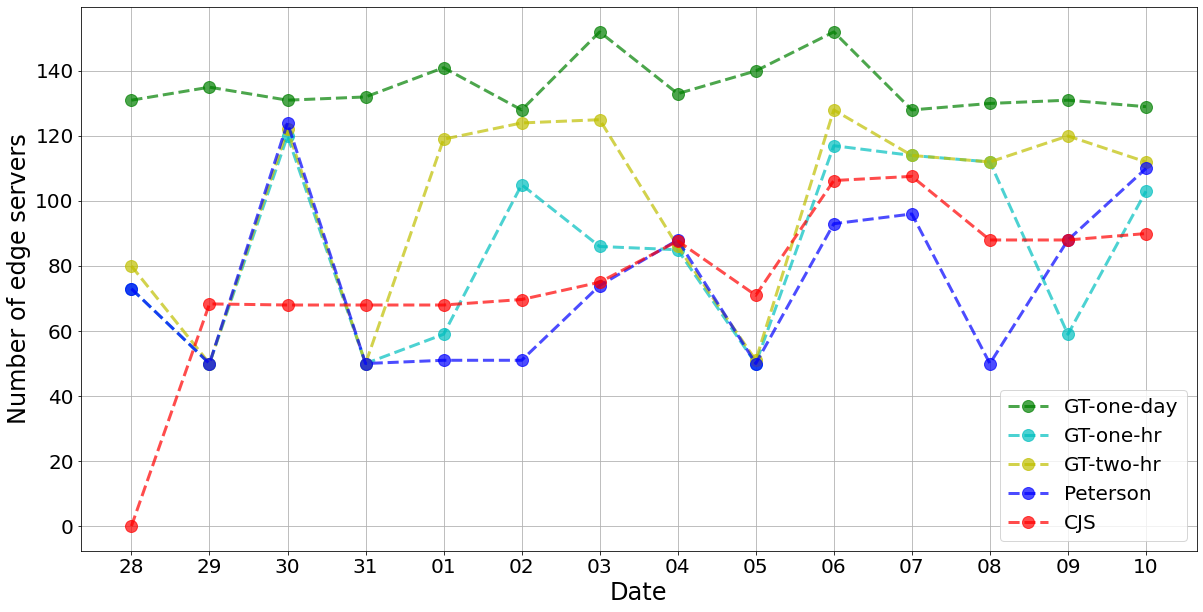

In [597]:
#CJS 8am 0.25 hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['28', '29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
ax.set_xlabel('Date', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, GT_one_day, "o--", markersize=12, linewidth=3, color='g', label='GT-one-day', alpha=0.7)
plt.plot(x_axis, GT_one_hr_8am, "o--", markersize=12, linewidth=3, color='c', label='GT-one-hr', alpha=0.7)
plt.plot(x_axis, GT_two_hr_8am, "o--", markersize=12, linewidth=3, color='y', label='GT-two-hr', alpha=0.7)
plt.plot(x_axis, peterson_est[0], "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, estimate_N_table_8am[0], "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()


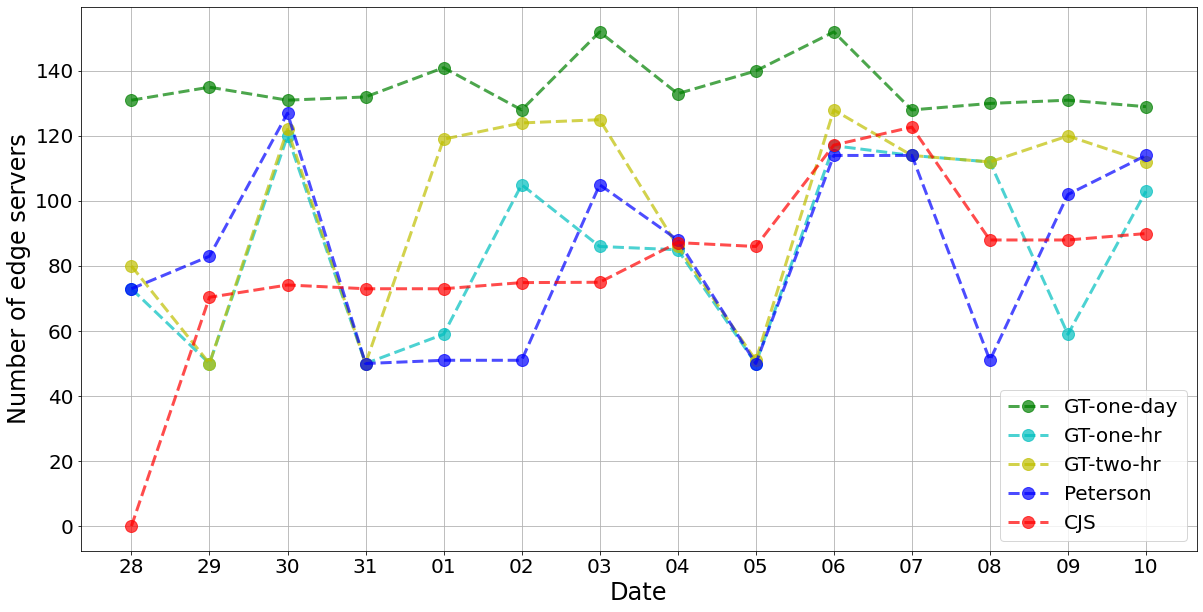

In [598]:
#CJS 8am 0.5 hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['28', '29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
ax.set_xlabel('Date', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, GT_one_day, "o--", markersize=12, linewidth=3, color='g', label='GT-one-day', alpha=0.7)
plt.plot(x_axis, GT_one_hr_8am, "o--", markersize=12, linewidth=3, color='c', label='GT-one-hr', alpha=0.7)
plt.plot(x_axis, GT_two_hr_8am, "o--", markersize=12, linewidth=3, color='y', label='GT-two-hr', alpha=0.7)
plt.plot(x_axis, peterson_est[1], "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, estimate_N_table_8am[1], "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()


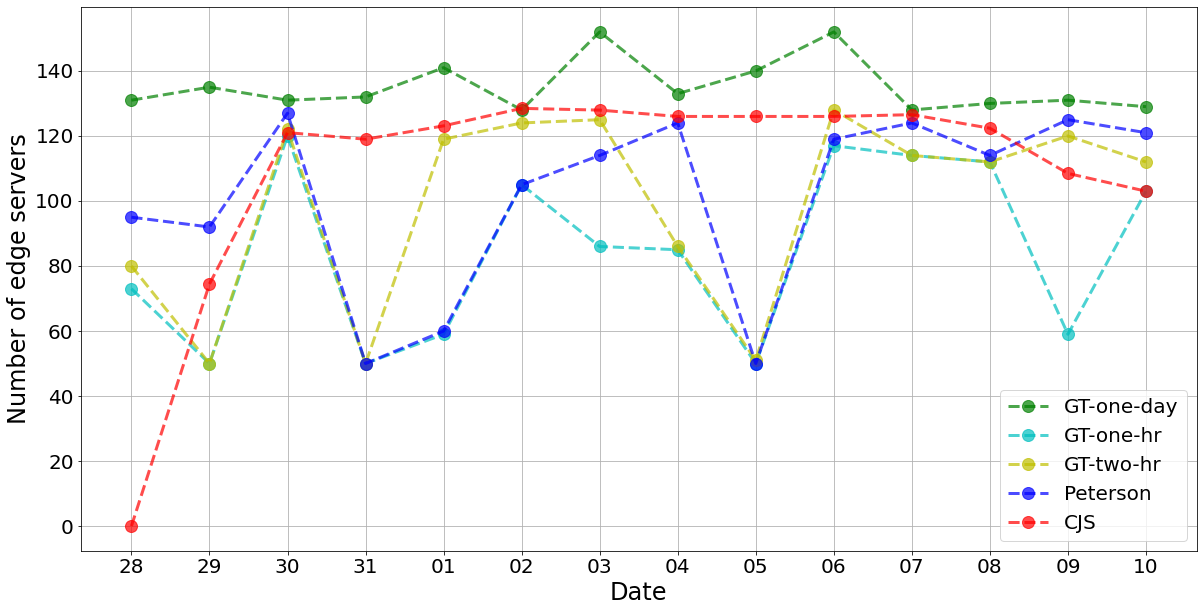

In [599]:
#CJS 8am 1 hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['28', '29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
ax.set_xlabel('Date', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, GT_one_day, "o--", markersize=12, linewidth=3, color='g', label='GT-one-day', alpha=0.7)
plt.plot(x_axis, GT_one_hr_8am, "o--", markersize=12, linewidth=3, color='c', label='GT-one-hr', alpha=0.7)
plt.plot(x_axis, GT_two_hr_8am, "o--", markersize=12, linewidth=3, color='y', label='GT-two-hr', alpha=0.7)
plt.plot(x_axis, peterson_est[2], "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, estimate_N_table_8am[2], "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()


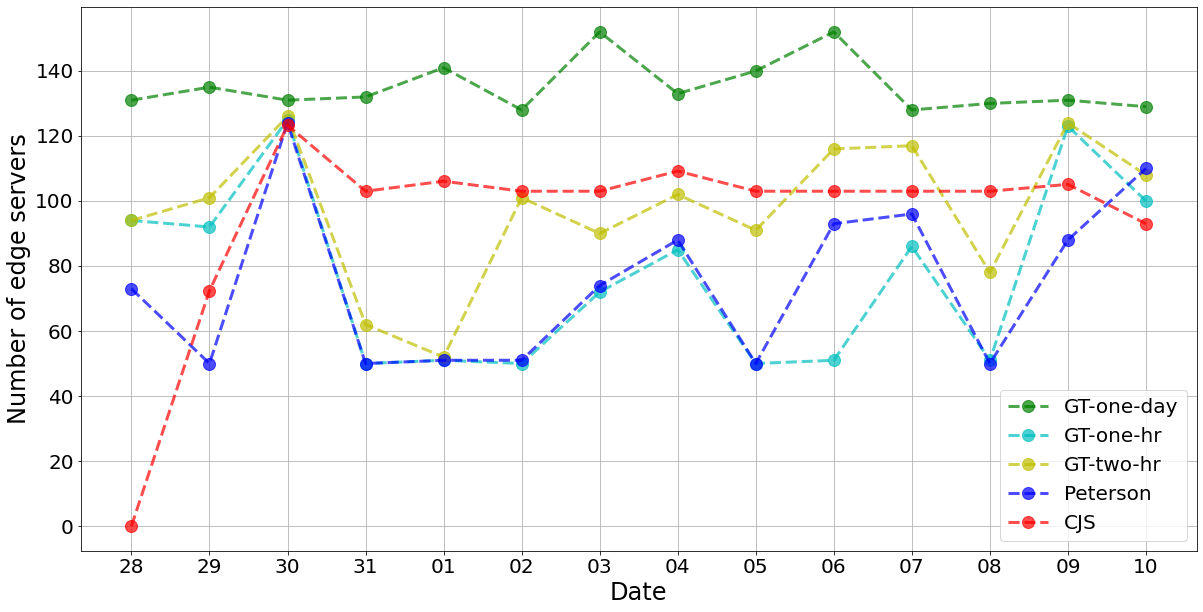

In [600]:
#CJS 4pm 0.25 hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['28', '29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
ax.set_xlabel('Date', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, GT_one_day, "o--", markersize=12, linewidth=3, color='g', label='GT-one-day', alpha=0.7)
plt.plot(x_axis, GT_one_hr_4pm, "o--", markersize=12, linewidth=3, color='c', label='GT-one-hr', alpha=0.7)
plt.plot(x_axis, GT_two_hr_4pm, "o--", markersize=12, linewidth=3, color='y', label='GT-two-hr', alpha=0.7)
plt.plot(x_axis, peterson_est[0], "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, estimate_N_table_4pm[0], "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()


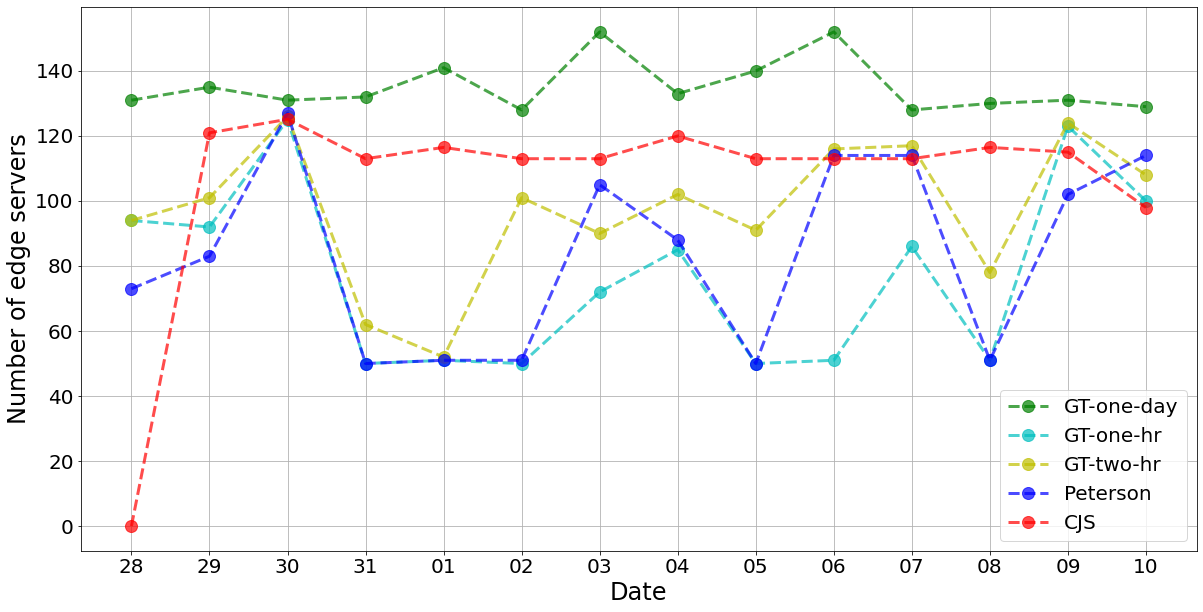

In [601]:
#CJS 4pm 0.5 hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['28', '29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
ax.set_xlabel('Date', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, GT_one_day, "o--", markersize=12, linewidth=3, color='g', label='GT-one-day', alpha=0.7)
plt.plot(x_axis, GT_one_hr_4pm, "o--", markersize=12, linewidth=3, color='c', label='GT-one-hr', alpha=0.7)
plt.plot(x_axis, GT_two_hr_4pm, "o--", markersize=12, linewidth=3, color='y', label='GT-two-hr', alpha=0.7)
plt.plot(x_axis, peterson_est[1], "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, estimate_N_table_4pm[1], "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()


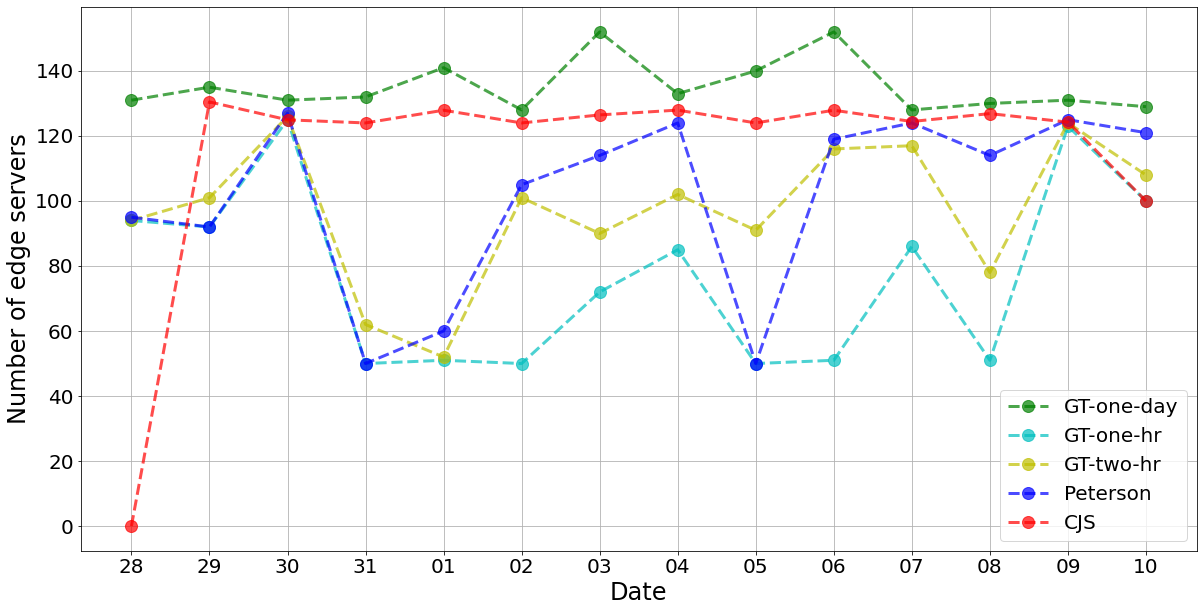

In [602]:
#CJS 4pm 1 hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['28', '29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
ax.set_xlabel('Date', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, GT_one_day, "o--", markersize=12, linewidth=3, color='g', label='GT-one-day', alpha=0.7)
plt.plot(x_axis, GT_one_hr_4pm, "o--", markersize=12, linewidth=3, color='c', label='GT-one-hr', alpha=0.7)
plt.plot(x_axis, GT_two_hr_4pm, "o--", markersize=12, linewidth=3, color='y', label='GT-two-hr', alpha=0.7)
plt.plot(x_axis, peterson_est[2], "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, estimate_N_table_4pm[2], "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()


CJS transaction vs Perterson transaction

In [594]:
peterson_trans_avg = np.mean(peterson_trans, axis=1)
C_tran_table_8am_avg = np.mean(C_tran_table_8am, axis=1)
print(peterson_trans_avg)
print(C_tran_table_8am_avg)

[  7905.64285714  14992.42857143  28310.78571429  56492.21428571
 107644.07142857 164135.07142857 216227.5       ]
[  3023.92857143   5507.          11465.71428571  23082.92857143
  48305.85714286  77792.5        106868.5       ]


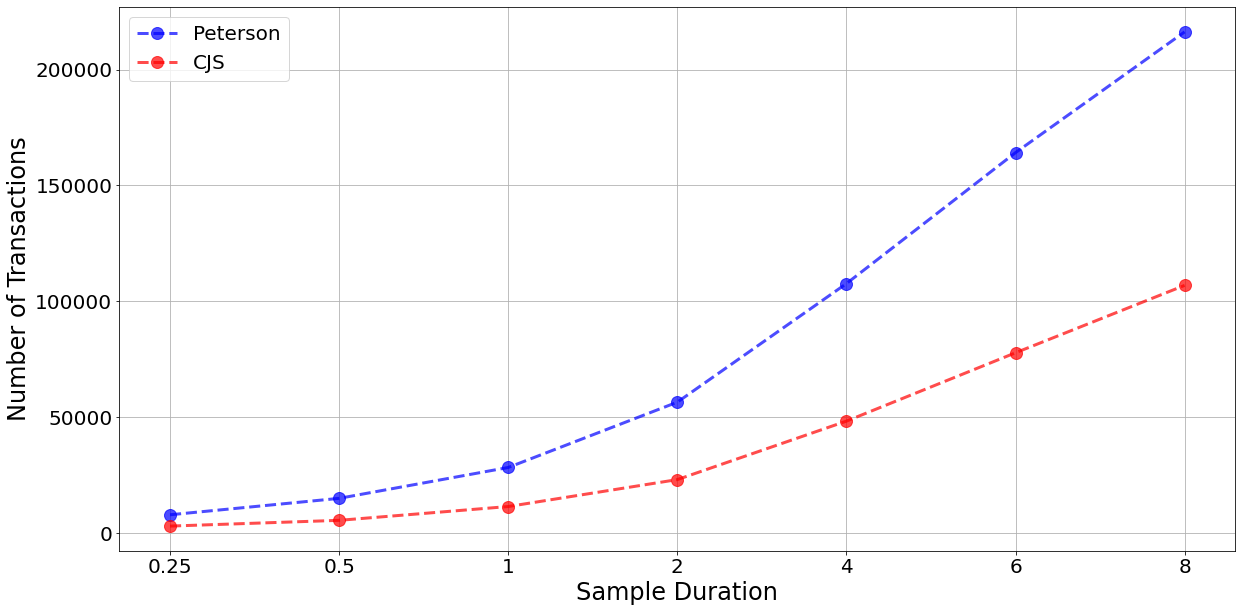

In [595]:
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['0.25', '0.5', '1', '2', '4', '6', '8']
ax.set_xlabel('Sample Duration', fontsize=24)
ax.set_ylabel('Number of Transactions', fontsize=24)

plt.plot(x_axis, peterson_trans_avg, "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, C_tran_table_8am_avg, "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()

In [603]:
peterson_trans_avg = np.mean(peterson_trans, axis=1)
C_tran_table_4pm_avg = np.mean(C_tran_table_4pm, axis=1)
print(peterson_trans_avg)
print(C_tran_table_4pm_avg)

[  7905.64285714  14992.42857143  28310.78571429  56492.21428571
 107644.07142857 164135.07142857 216227.5       ]
[  4881.71428571   9485.42857143  16845.07142857  33409.28571429
  59338.21428571  86342.57142857 109359.        ]


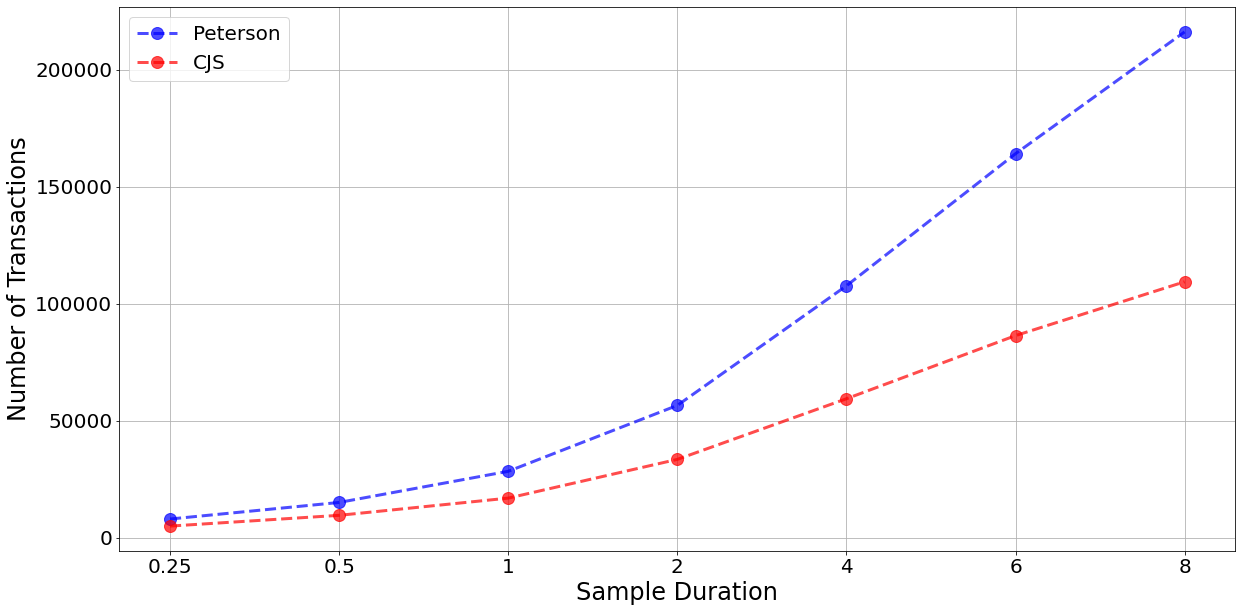

In [604]:
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['0.25', '0.5', '1', '2', '4', '6', '8']
ax.set_xlabel('Sample Duration', fontsize=24)
ax.set_ylabel('Number of Transactions', fontsize=24)

plt.plot(x_axis, peterson_trans_avg, "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, C_tran_table_4pm_avg, "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()

error calculation

In [605]:
peterson_err = np.sqrt(np.mean(np.abs(peterson_est-GT_one_day)/GT_one_day, axis=1)**2)
CJS_8am_err = np.sqrt(np.mean(np.abs(estimate_N_table_8am-GT_one_day)/GT_one_day, axis=1)**2)
print(peterson_err)
print(CJS_8am_err)

[0.44359427 0.37961958 0.24564323 0.14697738 0.07909613 0.01743296
 0.00851481]
[0.44193482 0.40839948 0.19136982 0.15968113 0.13223362 0.09802885
 0.09505377]


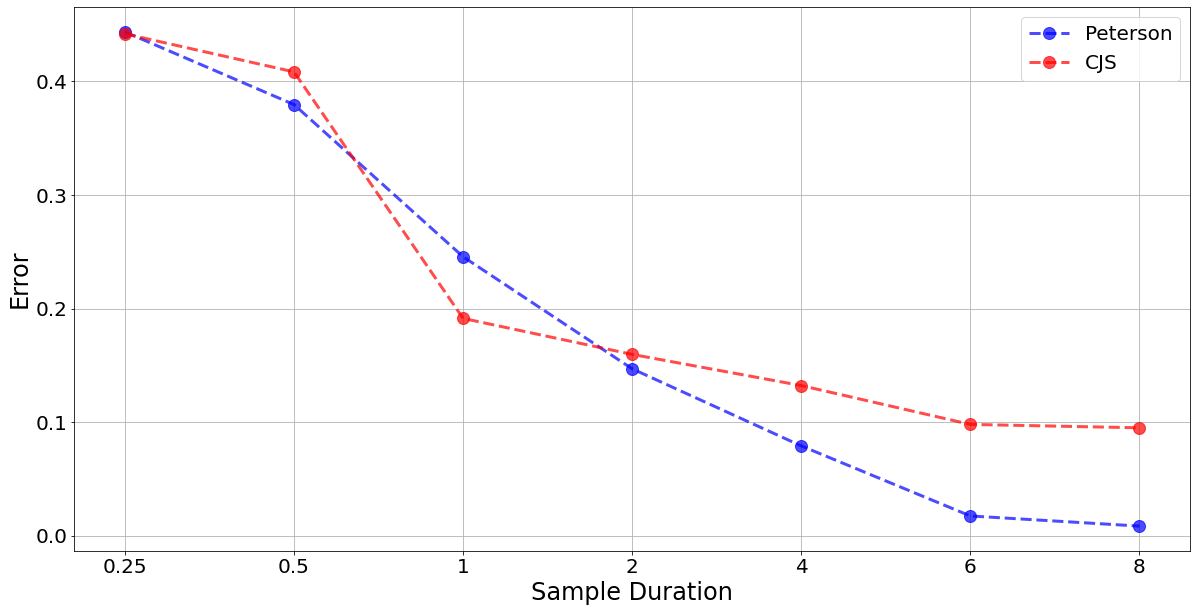

In [606]:
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['0.25', '0.5', '1', '2', '4', '6', '8']
ax.set_xlabel('Sample Duration', fontsize=24)
ax.set_ylabel('Error', fontsize=24)

plt.plot(x_axis, peterson_err, "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, CJS_8am_err, "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()

In [608]:
peterson_err = np.sqrt(np.mean(np.abs(peterson_est-GT_one_day)/GT_one_day, axis=1)**2)
CJS_4pm_err = np.sqrt(np.mean(np.abs(estimate_N_table_4pm-GT_one_day)/GT_one_day, axis=1)**2)
print(peterson_err)
print(CJS_4pm_err)

[0.44359427 0.37961958 0.24564323 0.14697738 0.07909613 0.01743296
 0.00851481]
[0.29663069 0.2122322  0.14794692 0.1337114  0.11284955 0.10906121
 0.10440295]


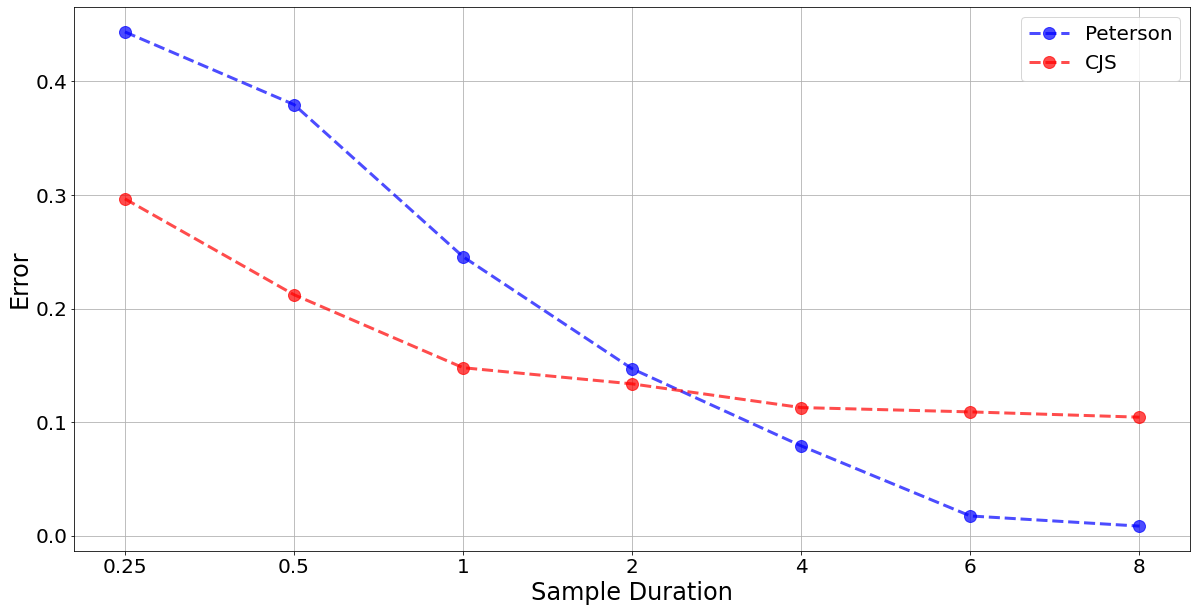

In [609]:
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['0.25', '0.5', '1', '2', '4', '6', '8']
ax.set_xlabel('Sample Duration', fontsize=24)
ax.set_ylabel('Error', fontsize=24)

plt.plot(x_axis, peterson_err, "o--", markersize=12, linewidth=3, color='b', label='Peterson', alpha=0.7)
plt.plot(x_axis, CJS_4pm_err, "o--", markersize=12, linewidth=3, color='r', label='CJS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=20)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()